In [ ]:
figsize('inline_short')

from collections import OrderedDict
import glob
import itertools
import json
import random
from typing import List

import sklearn.utils
from skm import SKM

import metadata
from util import *

In [ ]:
# Load recordings paths
recs_paths = pd.DataFrame([
    OrderedDict(
        path=path,
    )
    for path in flatten(glob.glob(f'{data_dir}/{g}') for g in [
        'peterson-field-guide/*/audio/*',
        'recordings/*',
        'recordings-new/*',
    ])
    if not os.path.isdir(path)
])
display(
    recs_paths.shape,
    pd.concat([
        recs_paths[:5],
        recs_paths[-5:],
    ]),
    recs_paths.path.map(lambda path: os.path.relpath(path, data_dir).split('/')[0]).value_counts(),
)

(478, 1)

,path
0,/Users/danb/hack/bubo/data/peterson-field-guide/bewwre/audio/43220301 Song.mp3
1,/Users/danb/hack/bubo/data/peterson-field-guide/bewwre/audio/43220321 Song.mp3
2,/Users/danb/hack/bubo/data/peterson-field-guide/bewwre/audio/43220351 Song.mp3
3,/Users/danb/hack/bubo/data/peterson-field-guide/bewwre/audio/43220371 Song (2 types).mp3
4,"/Users/danb/hack/bubo/data/peterson-field-guide/bewwre/audio/43220391 Song, Chatter, Snarl, etc..mp3"
473,/Users/danb/hack/bubo/data/recordings-new/x 20180414 unknown- long rolling finchy- GG Park Botanical Gardens.wav
474,/Users/danb/hack/bubo/data/recordings-new/x mixed 20170514 various (community garden by christopher playground).wav
475,/Users/danb/hack/bubo/data/recordings-new/x mixed 20180415 mixed sparrows- glen canyon.wav
476,"/Users/danb/hack/bubo/data/recordings-new/x wren 20161023 wren sp, alert.wav"
477,/Users/danb/hack/bubo/data/recordings-new/x wren 20161023 wren sp.wav


peterson-field-guide    341
recordings-new           86
recordings               51
Name: path, dtype: int64

In [ ]:
# Load audio data for each recording
recs_audio = (recs_paths
    # [lambda df: df.species == 'WIWA'].reset_index(drop=True)  # For faster dev
    # [:10]  # For faster dev
    .assign(audio=lambda df: df.reset_index(drop=True).pipe(df_apply_with_progress, f=lambda rec:
        load_audio(rec.path, cache=True, verbose=False)
    ))
)
display(
    recs_audio.shape,
    recs_audio.audio[:5],
)

Progress[0/478, .../s, ETA ...]: {'path': '/Users/danb/hack/bubo/data/peterson-field-guide/bewwre/audio/43220301 Song.mp3'}


Progress[478/478, 820/s, took 0.583s]


(478, 2)

0                          peterson-field-guide/bewwre/audio/43220301 Song: 1 channels, 16 bit, sampled @ 22.05 kHz, 10.632s long
1                          peterson-field-guide/bewwre/audio/43220321 Song: 1 channels, 16 bit, sampled @ 22.05 kHz, 17.162s long
2                          peterson-field-guide/bewwre/audio/43220351 Song: 1 channels, 16 bit, sampled @ 22.05 kHz, 49.136s long
3                peterson-field-guide/bewwre/audio/43220371 Song (2 types): 1 channels, 16 bit, sampled @ 22.05 kHz, 29.753s long
4    peterson-field-guide/bewwre/audio/43220391 Song, Chatter, Snarl, etc.: 1 channels, 16 bit, sampled @ 22.05 kHz, 27.011s long
Name: audio, dtype: object

In [ ]:
recs = (recs_audio
    .pipe(df_apply_with_progress, f=lambda row: pd.Series(dict(
        **row.to_dict(),
        name=row.audio.name,
        samples=row.audio.to_numpy_array(),
        **metadata.from_audio(row.audio),
    )))
    .drop(columns=['path'])
    .pipe(df_reorder_cols, first=['name', 'source', 'species', 'basename'], last=['audio', 'samples'])
)
display(
    recs.shape,
    recs[:5],
    recs.fillna('').groupby(['source', 'species'])[['name']].count(),
)

Progress[0/478, .../s, ETA ...]: {'path': '/Users/danb/hack/bubo/data/peterson-field-guide/bewwre/audio/43220301 Song.mp3', 'audio': peterson-field-guide/bewwre/audio/43220301 Song: 1 channels, 16 bit, sampled @ 22.05 kHz, 10.632s long}


Progress[0/478, .../s, ETA ...]: {'path': '/Users/danb/hack/bubo/data/peterson-field-guide/bewwre/audio/43220301 Song.mp3', 'audio': peterson-field-guide/bewwre/audio/43220301 Song: 1 channels, 16 bit, sampled @ 22.05 kHz, 10.632s long}


Progress[478/478, 576/s, took 0.83s]


(478, 7)

,name,source,species,basename,species_query,audio,samples
0,peterson-field-guide/bewwre/audio/43220301 Song,peterson-field-guide,BEWR,43220301 Song,bewwre,"peterson-field-guide/bewwre/audio/43220301 Song: 1 channels, 16 bit, sampled @ 22.05 kHz, 10.632s long",[ 0 0 -1 ... 0 0 0]
1,peterson-field-guide/bewwre/audio/43220321 Song,peterson-field-guide,BEWR,43220321 Song,bewwre,"peterson-field-guide/bewwre/audio/43220321 Song: 1 channels, 16 bit, sampled @ 22.05 kHz, 17.162s long",[ 0 0 0 ... -1 0 1]
2,peterson-field-guide/bewwre/audio/43220351 Song,peterson-field-guide,BEWR,43220351 Song,bewwre,"peterson-field-guide/bewwre/audio/43220351 Song: 1 channels, 16 bit, sampled @ 22.05 kHz, 49.136s long",[0 0 0 ... 1 0 0]
3,peterson-field-guide/bewwre/audio/43220371 Song (2 types),peterson-field-guide,BEWR,43220371 Song (2 types),bewwre,"peterson-field-guide/bewwre/audio/43220371 Song (2 types): 1 channels, 16 bit, sampled @ 22.05 kHz, 29.753s long",[ 0 -1 1 ... 0 1 -1]
4,"peterson-field-guide/bewwre/audio/43220391 Song, Chatter, Snarl, etc.",peterson-field-guide,BEWR,"43220391 Song, Chatter, Snarl, etc.",bewwre,"peterson-field-guide/bewwre/audio/43220391 Song, Chatter, Snarl, etc.: 1 channels, 16 bit, sampled @ 22.05 kHz, 27.011s long",[1 1 0 ... 0 0 0]


name
source               species      
peterson-field-guide BCCH       19
                     BCTI       20
                     BEWR       19
                     BOCH       12
                     BUSH       12
                     CACH       18
                     CACW       14
                     CANW       15
                     CARW       19
                     CEDW        7
                     HOWR       20
                     MAWR       20
                     RBNU       16
                     ROWR       13
                     SEWR       11
                     SOSP       19
                     TUTI       26
                     WBNU       17
                     WCSP       20
                     WIWA       15
                     WIWR        9
recordings           XX         51
recordings-new       BEWR        3
                     CATH        2
                     CEDW        1
                     GRCA        1
                     MAWR        1
                     OCWA        1
                     SOSP        8
                     STJA        1
                     WCSP       18
                     WIWA       16
                     XX         34

In [ ]:
# Names for easier dev (better autocomplete)
rec0 = recs[lambda df: df.species == 'WIWA'].iloc[1]
audio0 = rec0.audio

In [ ]:
# Manually step through featurize
rec_or_audio_or_signal = rec0
(rec, audio, x, sample_rate) = unpack_rec(rec_or_audio_or_signal)

spectro_f_min = 1000
spectro_f_bins = 40
spectro_hop_length = 256
spectro_frame_length = 512
spectro_frame_window = 'hann'
patch_length = 4
proj_skm_pca_var = .99
proj_skm_k = 500
agg_funs = ['mean', 'std', 'max']

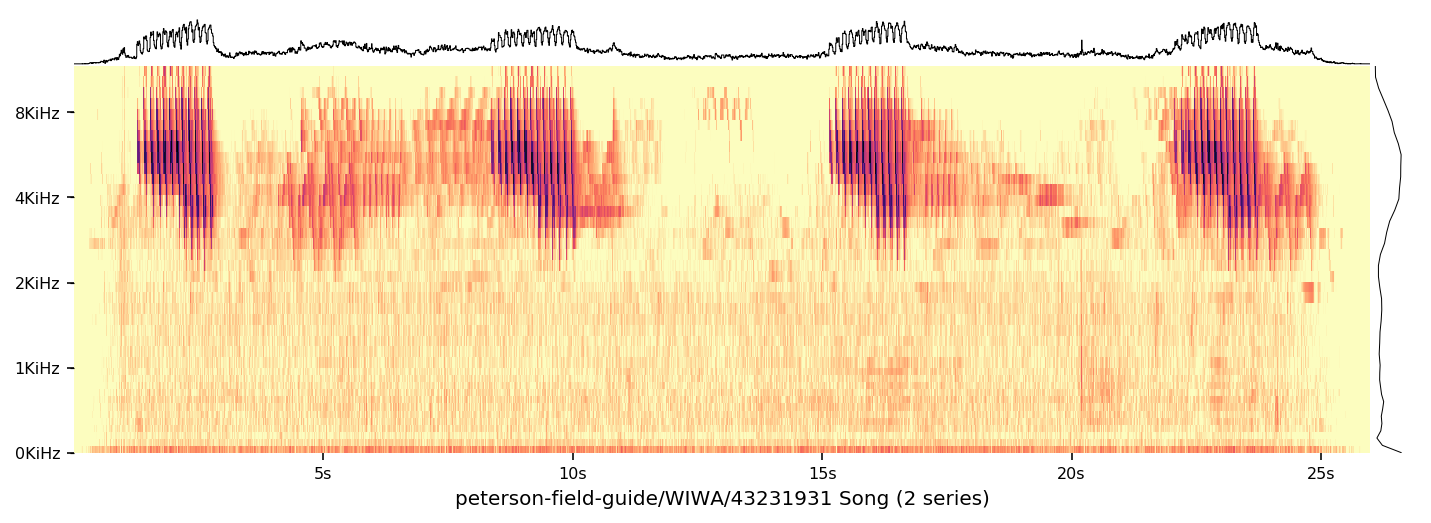

In [ ]:
# Spectro(audio_prefix).plot(fancy=False); plt.show()
# Melspectro(audio_prefix).plot(fancy=False); plt.show()
spectro = Melspectro(
    rec_or_audio_or_signal,
    nperseg=spectro_frame_length,
    overlap=1 - spectro_hop_length / spectro_frame_length,
    window=spectro_frame_window,
    n_mels=spectro_f_bins,
)
spectro.plot(show_audio=False)
plt.show()

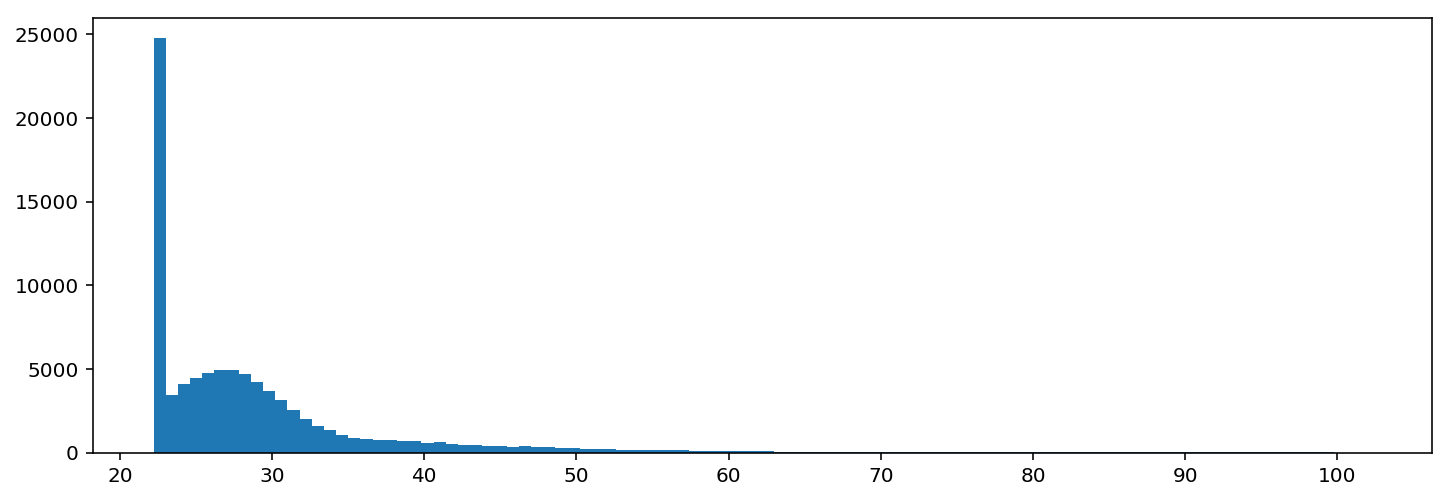

In [ ]:
# TODO Normalize so that S values (log powers) are comparable across recordings
#   - RMS [SP14]
#   - Median-based thresholding [SP14]
#   - ? [SBF16]
(f, t, S) = spectro
plt.hist(S.flatten(), bins=100); plt.show()

In [ ]:
recs_to_X = lambda recs: [Recording(**row) for i, row in recs.iterrows()]
recs_to_y = lambda recs: np.array(recs.species)

In [ ]:
# TODO Manually step through model flow
from sp14.model import *
model = Model(verbose_params=True)

train_n, test_n = 10, 20
recs_shuf = sklearn.utils.shuffle(recs, random_state=0)
recs_train, recs_test = recs_shuf[:train_n], recs_shuf[train_n : train_n + test_n]
recs_train_X, recs_test_X = recs_to_X(recs_train), recs_to_X(recs_test)
recs_train_y, recs_test_y = recs_to_y(recs_train), recs_to_y(recs_test)
model.fit_proj(recs_train_X);
model.fit_class(recs_train_X, recs_train_y);
pred_y = model.predict(recs_test_X)

[01:44:27.656] init:params
  rec_sample_rate: 22050 Hz
  spectro_f_min: 1000 Hz
    f_max: 11025 Hz
  spectro_f_bins (f): 40 freq bins
  spectro_hop_length: 256 samples (11.6 ms)
  spectro_frame_length: 512 samples (23.2 ms)
    frame_overlap: 50% overlap (256 samples)
    frames/s (t/s): 86.1 samples/s
  spectro_frame_window: '''hann'''
  norm: '[TODO]'
  patch_length (p): 4 frames (46.4 ms)
  proj_skm_pca_var: 99% variance
  proj_skm_k: 500 clusters
  agg_funs: '[''mean'', ''std'', ''max'']'
    a: 3 aggs
    features: 1500 features
  class_knn_k: 3
[01:44:27.659] init:pipeline
  spectro: (f, t)   (40, 86.1/s)
  patch  : (f*p, t) (40*4, 86.1/s)
  proj   : (k, t)   (500, 86.1/s)
  agg    : (k, a)   (500, 3)
  feat   : (k*a,)   (1500,)
[01:44:27.666] patches:recs
  len(recs): 10
  (samples,): [418752, 472896, 759168, 499968, 1926086, 342720, 303552, 107508, 320832, 523008]


[01:44:28.073] patches:spectros
  (f, t): [[40, 1634], [40, 1846], [40, 2964], [40, 1952], [40, 7522], [40, 1337], [40, 1184], [40, 418], [40, 1252], [40, 2042]]
[01:44:28.134] patches:patches
  (f*p, t): [[160, 1631], [160, 1843], [160, 2961], [160, 1949], [160, 7519], [160, 1334], [160, 1181], [160, 415], [160, 1249], [160, 2039]]
[01:44:28.148] fit_proj:skm_X
  skm_X.shape: [160, 22121]


[01:44:30.909] fit_proj:skm.fit
  skm.pca.components_.shape: [91, 160]
  skm.D.shape: [91, 500]
[01:44:30.913] patches:recs
  len(recs): 10
  (samples,): [418752, 472896, 759168, 499968, 1926086, 342720, 303552, 107508, 320832, 523008]


[01:44:31.362] patches:spectros
  (f, t): [[40, 1634], [40, 1846], [40, 2964], [40, 1952], [40, 7522], [40, 1337], [40, 1184], [40, 418], [40, 1252], [40, 2042]]
[01:44:31.430] patches:patches
  (f*p, t): [[160, 1631], [160, 1843], [160, 2961], [160, 1949], [160, 7519], [160, 1334], [160, 1181], [160, 415], [160, 1249], [160, 2039]]


[01:44:31.629] fit_class:knn_Xy
  (f*p, t): [[160, 1631], [160, 1843], [160, 2961], [160, 1949], [160, 7519], [160, 1334], [160, 1181], [160, 415], [160, 1249], [160, 2039]]
[01:44:31.632] fit_class:knn
  knn.get_params: {algorithm: auto, leaf_size: 30, metric: minkowski, metric_params: null, n_jobs: 1, n_neighbors: 3, p: 2, weights: uniform}
  knn.classes_: [BCCH, BEWR, CACH, CARW, HOWR, MAWR, XX]
[01:44:31.633] patches:recs
  len(recs): 20
  (samples,): [2818205, 417600, 469440, 569088, 433152, 725760, 351360, 684288, 373824, 899509, 379584, 466560, 829103, 388800, 6485468, 567936, 717066, 587520, 899136, 1389150]


[01:44:33.182] patches:spectros
  (f, t): [[40, 11007], [40, 1630], [40, 1832], [40, 2222], [40, 1691], [40, 2834], [40, 1371], [40, 2672], [40, 1459], [40, 3512], [40, 1481], [40, 1821], [40, 3237], [40, 1517], [40, 25332], [40, 2217], [40, 2800], [40, 2294], [40, 3511], [40, 5425]]


[01:44:33.418] patches:patches
  (f*p, t): [[160, 11004], [160, 1627], [160, 1829], [160, 2219], [160, 1688], [160, 2831], [160, 1368], [160, 2669], [160, 1456], [160, 3509], [160, 1478], [160, 1818], [160, 3234], [160, 1514], [160, 25329], [160, 2214], [160, 2797], [160, 2291], [160, 3508], [160, 5422]]


[01:44:34.069] predict:classes


In [ ]:
# TODO Step through model.predict(recs_test_X)

In [ ]:
recs_for_pred = recs_test
y = recs_to_y(recs_for_pred)
patches = model.patches(recs_to_X(recs_for_pred))
feats = model.feats(patches)  # (skm.transform)
# [x.shape for x in feats]

[02:09:41.229] patches:recs
  len(recs): 20
  (samples,): [2818205, 417600, 469440, 569088, 433152, 725760, 351360, 684288, 373824, 899509, 379584, 466560, 829103, 388800, 6485468, 567936, 717066, 587520, 899136, 1389150]


[02:09:42.770] patches:spectros
  (f, t): [[40, 11007], [40, 1630], [40, 1832], [40, 2222], [40, 1691], [40, 2834], [40, 1371], [40, 2672], [40, 1459], [40, 3512], [40, 1481], [40, 1821], [40, 3237], [40, 1517], [40, 25332], [40, 2217], [40, 2800], [40, 2294], [40, 3511], [40, 5425]]


[02:09:42.996] patches:patches
  (f*p, t): [[160, 11004], [160, 1627], [160, 1829], [160, 2219], [160, 1688], [160, 2831], [160, 1368], [160, 2669], [160, 1456], [160, 3509], [160, 1478], [160, 1818], [160, 3234], [160, 1514], [160, 25329], [160, 2214], [160, 2797], [160, 2291], [160, 3508], [160, 5422]]


In [ ]:
pd.concat(axis=1, objs=[
    pd.DataFrame({'y': y}),  # Labels for validation
    model._predict_class(feats, type='classes'),
])

[02:09:43.865] predict:classes


,y,0,1,2,3,4,5,6
0,XX,BCCH0.333,CACH0.333,CARW0.333,BEWR 0,HOWR 0,MAWR 0,XX 0
1,CACH,CACH0.667,MAWR0.333,BCCH 0,BEWR 0,CARW 0,HOWR 0,XX 0
2,CARW,CARW0.667,XX0.333,BCCH 0,BEWR 0,CACH 0,HOWR 0,MAWR 0
3,WIWA,CACH0.667,CARW0.333,BCCH 0,BEWR 0,HOWR 0,MAWR 0,XX 0
4,HOWR,CARW0.667,CACH0.333,BCCH 0,BEWR 0,HOWR 0,MAWR 0,XX 0
5,SEWR,CACH0.333,CARW0.333,MAWR0.333,BCCH 0,BEWR 0,HOWR 0,XX 0
6,BUSH,CACH0.333,CARW0.333,XX0.333,BCCH 0,BEWR 0,HOWR 0,MAWR 0
7,CANW,CARW0.667,MAWR0.333,BCCH 0,BEWR 0,CACH 0,HOWR 0,XX 0
8,WCSP,BCCH0.333,CARW0.333,XX0.333,BEWR 0,CACH 0,HOWR 0,MAWR 0
9,XX,XX0.667,BCCH0.333,BEWR 0,CACH 0,CARW 0,HOWR 0,MAWR 0


In [ ]:
pd.concat(axis=1, objs=[
    pd.DataFrame({'y': y}),  # Labels for validation
    model._predict_class(feats, type='kneighbors'),
])

[02:09:43.984] predict:kneighbors


,y,0,1,2,3,4,5,6,7,8,9
0,XX,8 55CACH,655.2CARW,957.9BCCH,758XX,558.6CARW,161.6CACH,467XX,274.3MAWR,083.8BEWR,3 133HOWR
1,CACH,159.6CACH,272.2MAWR,872.8CACH,678.8CARW,581.1CARW,782.9 XX,9 84BCCH,497.9 XX,099.2BEWR,3 117HOWR
2,CARW,540.1CARW,644.6CARW,750XX,851.8CACH,953.7BCCH,268.3MAWR,470.2 XX,071.4BEWR,172.8CACH,3 140HOWR
3,WIWA,157.7CACH,874.7CACH,675.5CARW,781.2 XX,981.7BCCH,582.1CARW,282.3MAWR,495.4 XX,0 102BEWR,3 116HOWR
4,HOWR,651.7CARW,8 54CACH,556.6CARW,960.1BCCH,165.5CACH,765.8 XX,266.4MAWR,480.8 XX,082.8BEWR,3 125HOWR
5,SEWR,168.8CACH,273.4MAWR,680.2CARW,880.3CACH,583.1CARW,785.7 XX,990.3BCCH,0 98BEWR,499.8 XX,3 108HOWR
6,BUSH,747.3 XX,556.8CARW,860.5CACH,661.1CARW,962.9BCCH,168.9CACH,273.9MAWR,481.5 XX,085.6BEWR,3 139HOWR
7,CANW,6 74CARW,275.2MAWR,580.2CARW,885.8CACH,091.9BEWR,192.5CACH,994.8BCCH,798.4 XX,4100 XX,3 113HOWR
8,WCSP,753.1 XX,561.4CARW,9 65BCCH,866.5CACH,667.9CARW,170.8CACH,479.4 XX,283.5MAWR,086.7BEWR,3 146HOWR
9,XX,435.1 XX,742.2 XX,9 54BCCH,556.5CARW,661.5CARW,865.7CACH,071.5BEWR,284.3MAWR,191.8CACH,3 173HOWR
